# Imports + Base Code

In [2]:
import matplotlib.pyplot as plt
import numpy as np # useful for calculations
import h5py #required to read hdf5 files
import matplotlib as mpl
from tqdm import tqdm
from scipy import spatial
from scipy.optimize import curve_fit
import pdb
import pickle
from photutils.profiles import RadialProfile
from halotools.mock_observables import return_xyz_formatted_array
from halotools.mock_observables import radial_profile_3d


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.rcParams.update({
    'figure.figsize': (9, 6),
    'agg.path.chunksize': 2000,
    'xtick.direction': 'in',
    'xtick.major.size': 6,
    'xtick.major.width': 1,
    'ytick.direction': 'in',
    'ytick.major.size': 6,
    'ytick.major.width': 1,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.top': True,
    'ytick.right': True,
})

plt.style.use('dark_background')

FloatType = np.float64  # double precision: np.float64, for single use np.float32

def read_gadget_snapshot(file_name):
	data = h5py.File(file_name, 'r')  # load full hdf5 file
	time = FloatType(data['Header'].attrs['Time']) # the scale factor at which snapshot was written
	BoxSize = FloatType(data['Header'].attrs['BoxSize']) # box size in code units (Mpc)
	Pos = np.array(data['PartType1']['Coordinates'], dtype=FloatType) #3d Positions of all particles, e.g. x coord: Pos[:,0]
	mass = FloatType(data['Header'].attrs['MassTable'][1]) # mass of one DM particle
	n_particles = Pos.size // 3
	return time, Pos, mass, n_particles, BoxSize

file_name = "snapshot_002.hdf5"
time, Pos, mass, n_particles, BoxSize = read_gadget_snapshot(file_name)

# Friends of Friends Algorithm

In [3]:
# mean distance:
box_vol = BoxSize**3
mean_dist = (box_vol/n_particles)**(1/3)
print('mean distance between particles = {}'.format(mean_dist))

# linking length:
linking_length = mean_dist*0.2
print('mean distance:', mean_dist, 'Mpc')
print('linking_length = ', linking_length)

# distance between ith and jth particle:
def particle_distance(i, j, positions):
    x_i, y_i, z_i = positions[i, 0], positions[i, 1], positions[i, 2]
    x_j, y_j, z_j = positions[j, 0], positions[j, 1], positions[j, 2]
    return np.sqrt((x_i - x_j)**2 + (y_i - y_j)**2 + (z_i - z_j)**2)

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query_pairs.html
tree = spatial.cKDTree(Pos)
pairs = tree.query_pairs(r=linking_length, output_type='ndarray') # unique pairs of all points within linking length of one another

mean distance between particles = 0.3125
mean distance: 0.3125 Mpc
linking_length =  0.0625


In [3]:
# first attempt at finding friends:

# all_particles = np.linspace(0, n_particles - 1, n_particles)
# lonely = all_particles
# num_groups = 0
# friend_dict = {}

# for i in range(n_particles):  # Generates numbers from 0 to 10
#     friend_dict[i] = []

# for i in tqdm(range(n_particles)):
#     print('on particle {}'.format(i))
#     # for j in tqdm(range(len(lonely))):
#     for j in range(i+1, n_particles): # vb changed to look at the upper triangle in the nxn particle matrix since it's symmetric ij vs ji, removed 2nd tqdm since would print 2 million times for each i

#         dist = particle_distance(i, j, Pos)
#         # print('potential neighbors {}'.format(j))
#         # print(dist)
#         # check if the particles are friends
#         if dist < linking_length:
#             friend_dict[i].append(j)
#             friend_dict[j].append(i)
#             # print('particle {} and {} are friends'.format(i, j))
#         else:
#             # particles are not friends
#             continue

In [5]:
# for i, j in friend_pairs:
#     friend_dict[i].append(j)
#     friend_dict[j].append(i)

# chatgpt did this because appending particle by particle was taking an inconceivable amount of time

src = np.r_[pairs[:,0], pairs[:,1]]
dst = np.r_[pairs[:,1], pairs[:,0]]
order = np.argsort(src)
src = src[order]; dst = dst[order]
friends = np.split(dst, np.cumsum(np.bincount(src, minlength=n_particles))[:-1])


In [7]:
"""
general idea:
    choose a particle that hasn't been checked yet
    assign a new halo to it
    make a list of new particles to check - initially the list of that particle's friends
    for each particle in the to_check list, 
    see if it's been checked, and if not, add it to the halo, and add its friends to the to_check list
    continue until there are no particles left to check
    if there is 
    then find a new lonely particle and do the same thing
"""


checked = np.zeros(n_particles, dtype=bool)

halos = []
for i in tqdm(range(n_particles)):
    if not checked[i]: # find a particle that hasn't been checked yet 
        checked[i] = True
        halo = [i] # assign a halo to it
        to_check = list(friends[i]) # initialize a list of other particles to check / add to the halo
        while len(to_check)>0:
            particle = to_check.pop() # gets the index but removes that index from the list of particles to check
            if not checked[particle]:
                checked[particle] = True # mark that we've checked the particle
                halo.append(particle) # add prticle to halo
                to_check.extend(friends[particle]) # add its friends to the list of particles to check
        if len(halo) > 1:
            halos.append(halo)

100%|██████████| 2097152/2097152 [00:51<00:00, 40740.42it/s] 


# Halo Visualizations

In [4]:
with open('halos.pkl', 'rb') as file:
    halos = pickle.load(file)

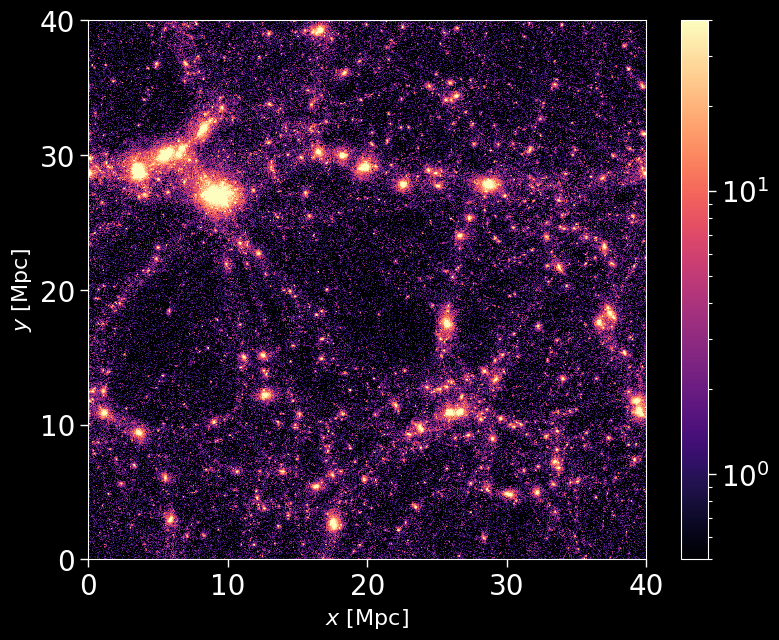

In [5]:
x=Pos[:, 0]
y=Pos[:, 1]
z=Pos[:, 2]

plt.rc('font', family='sans')
plt.rcParams.update({
    'agg.path.chunksize': 2000,
    'xtick.direction': 'out',
    'xtick.major.size': 6,
    'xtick.major.width': 1,
    'xtick.minor.size': 3,
    'xtick.minor.width': 0.8,
    'xtick.minor.visible': False,
    'ytick.direction': 'out',
    'ytick.major.size': 6,
    'ytick.major.width': 1,
    'ytick.minor.size': 3,
    'ytick.minor.width': 0.8,
    'ytick.minor.visible': False,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.top': False,
    'ytick.right': False,
})

# plt.figure(figsize=(9, 7))
# plt.hist2d(x, y, bins = 1000,  norm=mpl.colors.LogNorm(vmin=0.5, vmax=40), cmap = 'magma_r') 
# plt.xlabel('$x$ [Mpc]')
# plt.ylabel('$y$ [Mpc]')
# plt.colorbar()
# plt.xticks([0,10,20,30,40])
# plt.yticks([0,10,20,30,40])
# # plt.savefig('figures/structure_map.png', dpi=200, transparent=True)
# plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,7))
ax.set_facecolor('k')
plt.hist2d(x, y, bins = 1000,  norm=mpl.colors.LogNorm(vmin=0.5, vmax=40), cmap = 'magma') 
ax.set_xlabel('$x$ [Mpc]')
ax.set_ylabel('$y$ [Mpc]')
ax.set_xticks([0,10,20,30,40])
ax.set_yticks([0,10,20,30,40])
plt.colorbar()
plt.show()


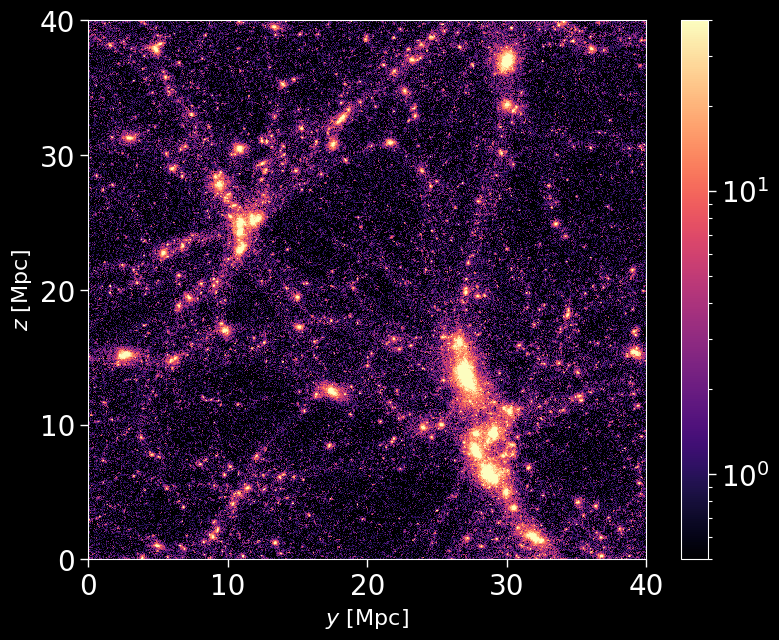

In [6]:
# plt.figure(figsize=(9,7))
# plt.hist2d(y, z, bins = 1000,  norm=mpl.colors.LogNorm(vmin=0.5, vmax=40), cmap ='magma_r') 
# plt.xlabel('$y$ [Mpc]')
# plt.ylabel('$z$ [Mpc]')
# plt.xticks([0,10,20,30,40])
# plt.yticks([0,10,20,30,40])
# plt.colorbar()
# # plt.savefig('figures/structure_map.png', dpi=200, transparent=True)
# plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,7))
ax.set_facecolor('k')
plt.hist2d(y, z, bins = 1000,  norm=mpl.colors.LogNorm(vmin=0.5, vmax=40), cmap ='magma') 
ax.set_xlabel('$y$ [Mpc]')
ax.set_ylabel('$z$ [Mpc]')
ax.set_xticks([0,10,20,30,40])
ax.set_yticks([0,10,20,30,40])
plt.colorbar()
plt.show()

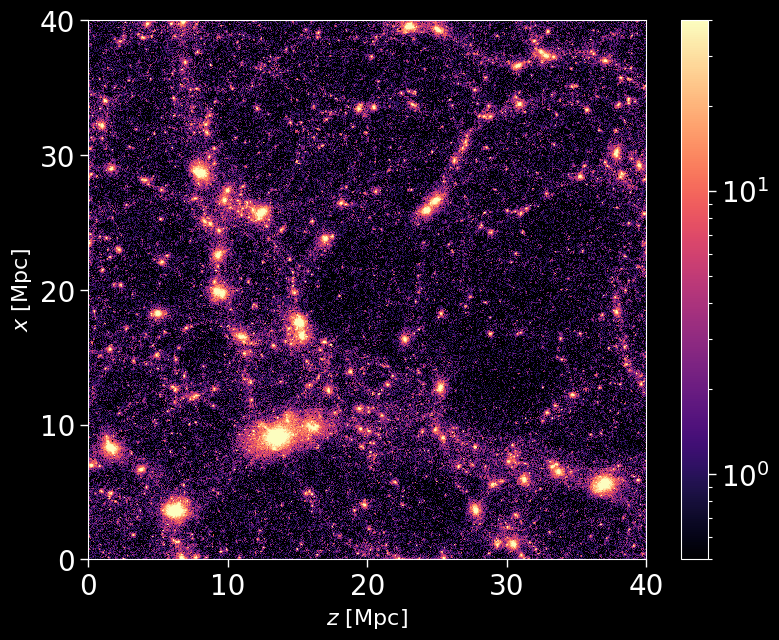

In [7]:
# plt.figure(figsize=(9,7))
# plt.hist2d(z, x, bins = 1000,  norm=mpl.colors.LogNorm(vmin=0.5, vmax=40), cmap ='magma_r') 
# plt.xlabel('$z$ [Mpc]')
# plt.ylabel('$x$ [Mpc]')
# plt.xticks([0,10,20,30,40])
# plt.yticks([0,10,20,30,40])
# plt.colorbar()
# # plt.savefig('figures/structure_map.png', dpi=200, transparent=True)
# plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,7))
ax.set_facecolor('k')
plt.hist2d(z, x, bins = 1000,  norm=mpl.colors.LogNorm(vmin=0.5, vmax=40), cmap ='magma') 
ax.set_xlabel('$z$ [Mpc]')
ax.set_ylabel('$x$ [Mpc]')
ax.set_xticks([0,10,20,30,40])
ax.set_yticks([0,10,20,30,40])
plt.colorbar()
plt.show()

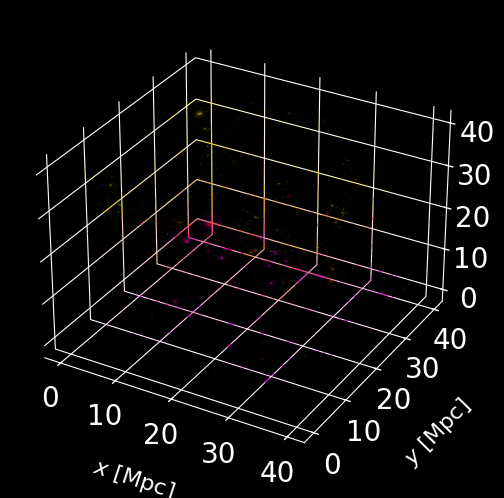

In [19]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x,y,z, s=0.07, alpha=0.01, c=z, cmap='spring')
ax.set_xlabel('$x$ [Mpc]', labelpad=20)
ax.set_ylabel('$y$ [Mpc]', labelpad=20)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# plt.xlabel('$x$ [Mpc]')
# plt.ylabel('$y$ [Mpc]')
# plt.zlabel('$z$ [Mpc]')

# plt.savefig('figures/3d_map_snapshot002_colorz.png', dpi=200)

plt.show()

# Third Largest Halo Radial Profile + NFW Fit

In [8]:
sizes = np.array([len(h) for h in halos])
halo3 = halos[2]
n_halo3 = len(halo3)
Pos3 = Pos[halo3]
x3=Pos3[:, 0]
y3=Pos3[:, 1]
z3=Pos3[:, 2]

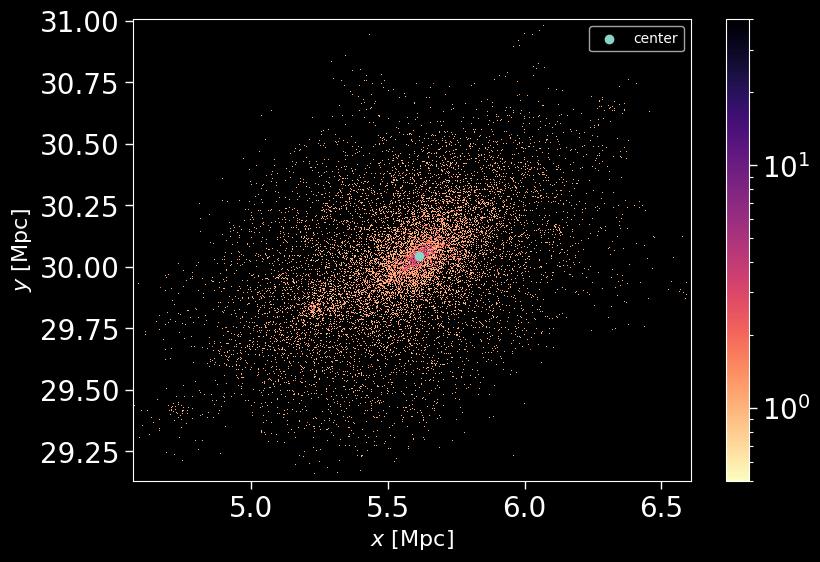

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('k')
plt.hist2d(x3, y3, bins = 1000,  norm=mpl.colors.LogNorm(vmin=0.5, vmax=40), cmap = 'magma_r') 
ax.set_xlabel('$x$ [Mpc]')
ax.set_ylabel('$y$ [Mpc]')
plt.colorbar()
plt.scatter(x3[4422], y3[4422], label = 'center')
plt.legend()

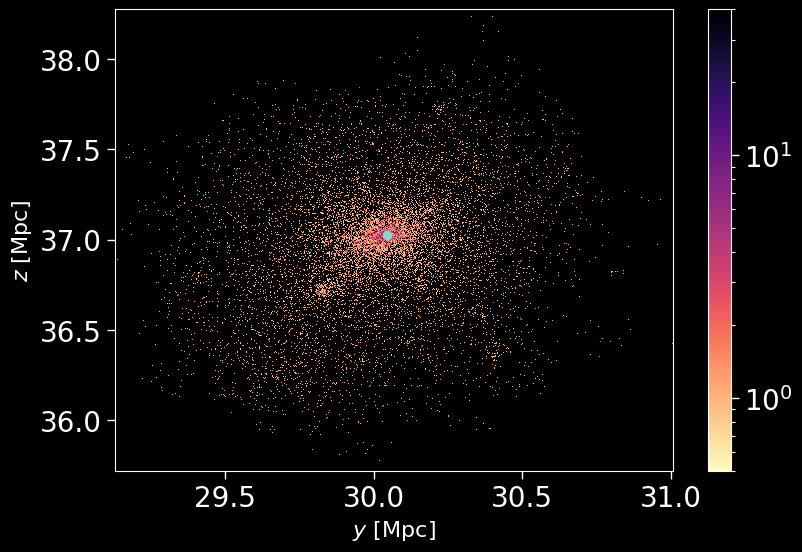

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('k')
plt.hist2d(y3, z3, bins = 1000,  norm=mpl.colors.LogNorm(vmin=0.5, vmax=40), cmap = 'magma_r') 
ax.set_xlabel('$y$ [Mpc]')
ax.set_ylabel('$z$ [Mpc]')
plt.colorbar()
plt.scatter(y3[4422], z3[4422])

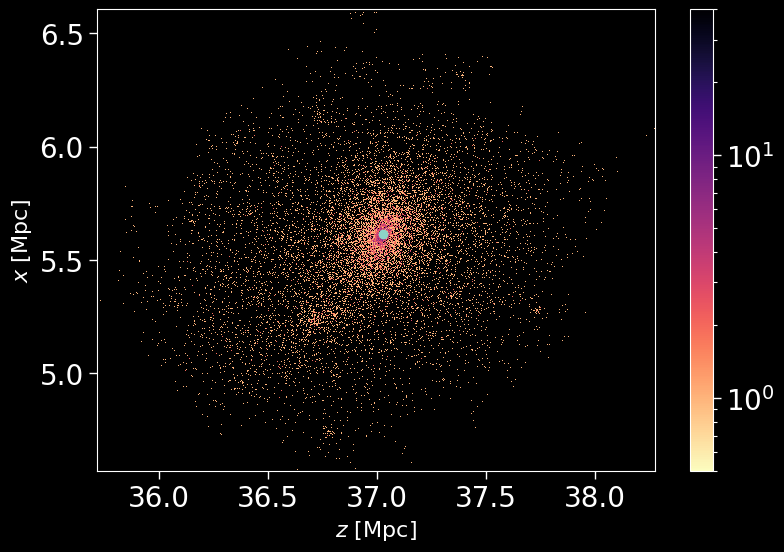

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('k')
plt.hist2d(z3, x3, bins = 1000,  norm=mpl.colors.LogNorm(vmin=0.5, vmax=40), cmap = 'magma_r') 
ax.set_xlabel('$z$ [Mpc]')
ax.set_ylabel('$x$ [Mpc]')
plt.colorbar()
plt.scatter(z3[4422], x3[4422])

In [25]:
sample1 = Pos3
center = Pos3[4422]
sample2 = center.reshape(1, 3)
sample2_quantity = np.ones(1)

# radial bins
r = np.linalg.norm(Pos3 - center, axis=1)
rbins = np.linspace(0, r.max(), 50)

profile = radial_profile_3d(
    sample1, 
    sample2,
    sample2_quantity,
    rbins_absolute=rbins
)

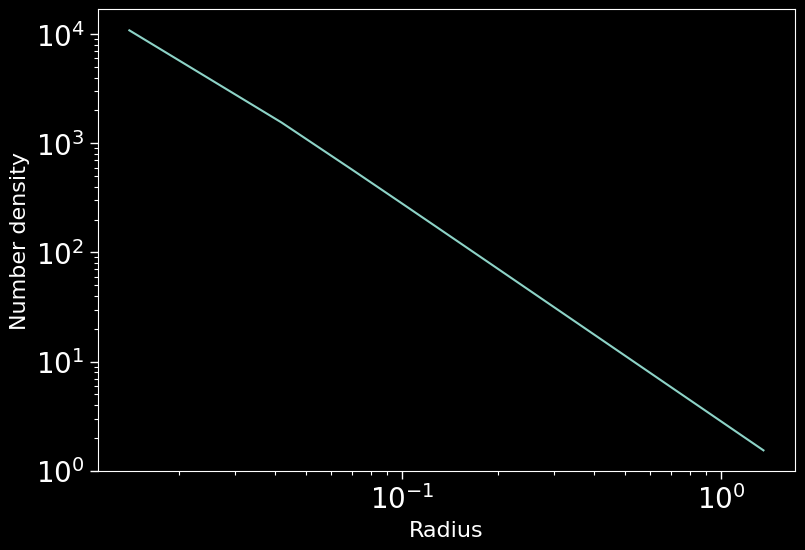

In [26]:
counts = profile[0]

r_inner = rbins[:-1]
r_outer = rbins[1:]
shell_vol = (4/3)*np.pi*(r_outer**3 - r_inner**3)

density = counts / shell_vol

r_mid = 0.5 * (r_inner + r_outer)

plt.plot(r_mid, density)
plt.xlabel("Radius")
plt.ylabel("Number density")
plt.yscale("log")
plt.xscale("log")
plt.show()


In [27]:
def nfw(r, rho_0, r_s):
    return rho_0 / ((r / r_s) * (1 + r / r_s)**2)

mask = np.isfinite(density) & (density > 0)
r_fit = r_mid[mask]
rho_fit = density[mask]

popt, pcov = curve_fit(
    lambda r, rho_s, r_s: nfw(r, rho_s, r_s),
    r_fit,
    rho_fit,
    p0=[np.max(rho_fit), np.median(r_fit)],  # initial guesses
    maxfev=20000
)

rho_s_fit, r_s_fit = popt
print("Best-fit NFW parameters:")
print(f"rho_0 = {rho_s_fit:.3e}")
print(f"r_s   = {r_s_fit:.3e}")

Best-fit NFW parameters:
rho_0 = 6.529e+03
r_s   = 4.160e-02


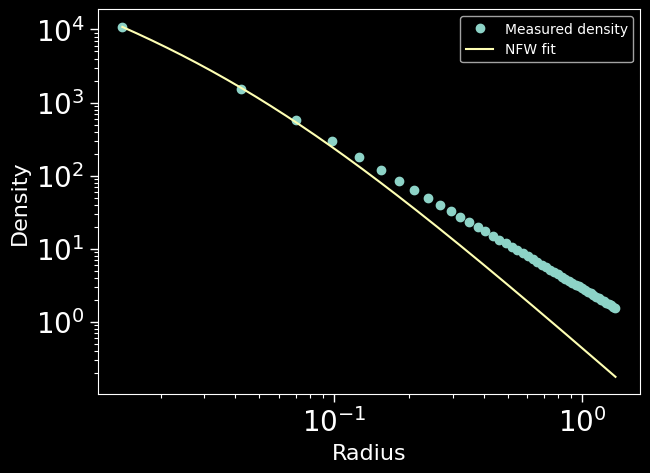

In [28]:
r_smooth = np.logspace(np.log10(r_fit.min()), np.log10(r_fit.max()), 200)
rho_smooth = nfw(r_smooth, rho_s_fit, r_s_fit)

plt.figure(figsize=(7,5))
plt.loglog(r_fit, rho_fit, 'o', label='Measured density')
plt.loglog(r_smooth, rho_smooth, '-', label='NFW fit')

plt.xlabel("Radius")
plt.ylabel("Density")
plt.legend()
plt.show()

In [21]:
from scipy.spatial import cKDTree

def find_density_peak(positions, n_neighbors=50):
    """Find particle with highest local density using k-nearest neighbors"""
    tree = cKDTree(positions)
    
    # For each particle, find distance to its nth nearest neighbor
    distances, indices = tree.query(positions, k=n_neighbors+1)  # +1 because it includes itself
    
    # Use inverse of distance to nth neighbor as density proxy
    # Smaller distance = more neighbors nearby = higher density
    local_density = 1.0 / distances[:, -1]  # distance to furthest of k neighbors
    
    # Find particle with highest density
    densest_idx = np.argmax(local_density)
    
    return positions[densest_idx], densest_idx

center, center_idx_in_halo = find_density_peak(Pos3, n_neighbors=50)
center_idx_in_Pos = halo3[center_idx_in_halo]

print(f"Density peak index in Pos3: {center_idx_in_halo}")
print(f"Density peak index in original Pos: {center_idx_in_Pos}")
print(f"Density peak position: {center}")

Density peak index in Pos3: 4422
Density peak index in original Pos: 224909
Density peak position: [ 5.61569548 30.04443932 37.02689362]


<>:48: SyntaxWarning: invalid escape sequence '\o'
<>:48: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_16627/1380453727.py:48: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("Density $[M_\odot \, \mathrm{{Mpc}}^{{-3}}]$")


Best-fit NFW parameters:
rho_0 = 4.408e+06
r_s   = 7.707e-02


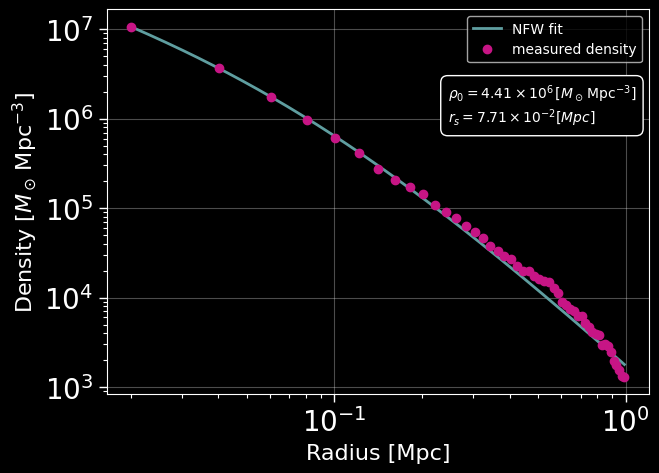

In [39]:
r = np.linalg.norm(Pos3 - center, axis=1)
rbins = np.linspace(0.01, 1, 50)
counts, _ = np.histogram(r, bins=rbins)

r_inner = rbins[:-1]
r_outer = rbins[1:]
shell_vol = (4/3) * np.pi * (r_outer**3 - r_inner**3)

density = counts / shell_vol
r_mid = 0.5 * (r_inner + r_outer)

mask = (density > 0)
r_fit = r_mid[mask]
rho_fit = density[mask]

popt, pcov = curve_fit(
    lambda r, rho_s, r_s: nfw(r, rho_s, r_s),
    r_fit,
    rho_fit,
    # p0=[np.max(rho_fit), np.median(r_fit)],  # initial guesses
    maxfev=20000
)

rho_s_fit, r_s_fit = popt
print("Best-fit NFW parameters:")
print(f"rho_0 = {rho_s_fit:.3e}")
print(f"r_s   = {r_s_fit:.3e}")

# Plot
r_smooth = np.logspace(np.log10(r_fit.min()), np.log10(r_fit.max()), 200)
rho_smooth = nfw(r_smooth, rho_s_fit, r_s_fit)

plt.figure(figsize=(7,5))

plt.loglog(r_smooth, rho_smooth, '-', linewidth=2, label='NFW fit', color='cadetblue')
plt.loglog(r_fit, rho_fit, 'o', label='measured density', markersize=6, color = 'mediumvioletred')

rho_str = rf"$\rho_0 = {rho_s_fit/10**int(np.floor(np.log10(rho_s_fit))):.2f} \times 10^{{{int(np.floor(np.log10(rho_s_fit)))}}} \, [M_\odot \, \mathrm{{Mpc}}^{{-3}}]$"
r_str = rf"$r_s = {r_s_fit/10**int(np.floor(np.log10(r_s_fit))):.2f} \times 10^{{{int(np.floor(np.log10(r_s_fit)))}}} [Mpc]$"
label = rho_str + "\n" + r_str

plt.text(0.245, 900000, label, 
         fontsize=10, 
         color='white', 
         bbox=dict(facecolor='k', boxstyle='round,pad=0.5'))

plt.xlabel("Radius [Mpc]")
plt.ylabel("Density $[M_\odot \, \mathrm{{Mpc}}^{{-3}}]$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [32]:
rho_s_fit

np.float64(4407504.781013725)

In [33]:
r_s_fit

np.float64(0.07706669220350332)

\begin{equation}
\rho(r) = \frac{\rho_0}{\frac{r}{R_s}(1 + \frac{r}{R_s})}^2
\end{equation}

In [ ]:
# Reasonable R200,crit


# Halo Mass Function

In [ ]:
# Create a histogram of the halo masses, similar to a halo mass function. Since one
# requires some amount of particles to resolve a halo, only take into account halos with
# at least 20 particles.
